Caio Passos de Lima Albuquerque - 5536506

Lab 4 - Avaliação de Modelos de IA

- Parte 1: Classificação (Iris)
- Parte 2: Regressão (California Housing)
- Parte 3: Clusterização (Wine)



In [1]:
# Imports gerais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.datasets import load_iris, load_wine, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix,
    roc_curve, roc_auc_score,
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score
)

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Parte 1 – Classificação (Iris Dataset)

Nesta parte vamos trabalhar com o Iris dataset para comparar modelos de classificação.

Modelos usados:
- KNN com k = 3
- KNN com k = 5
- Decision Tree (como terceiro modelo para a parte de ROC/AUC e comparação adicional)


In [2]:
# Carregando o dataset Iris
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

print("Formato de X:", X.shape)
print("Formato de y:", y.shape)
print("Classes:", class_names)

Formato de X: (150, 4)
Formato de y: (150,)
Classes: ['setosa' 'versicolor' 'virginica']


In [3]:
# Divisão treino/teste (70% / 30%) e normalização para KNN
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Tamanho treino:", X_train.shape[0])
print("Tamanho teste:", X_test.shape[0])

Tamanho treino: 105
Tamanho teste: 45


In [4]:
# Funções auxiliares para avaliação de classificadores
def avaliar_classificador(nome, modelo, X_tr, y_tr, X_te, y_te):
    modelo.fit(X_tr, y_tr)
    y_pred = modelo.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec_macro = precision_score(y_te, y_pred, average='macro')
    prec_micro = precision_score(y_te, y_pred, average='micro')
    rec_macro = recall_score(y_te, y_pred, average='macro')
    rec_micro = recall_score(y_te, y_pred, average='micro')
    f1_macro = f1_score(y_te, y_pred, average='macro')
    f1_micro = f1_score(y_te, y_pred, average='micro')
    cm = confusion_matrix(y_te, y_pred)

    print(f"\n=== {nome} ===")
    print(f"Acurácia: {acc:.4f}")
    print(f"Precisão macro: {prec_macro:.4f}")
    print(f"Precisão micro: {prec_micro:.4f}")
    print(f"Recall macro: {rec_macro:.4f}")
    print(f"Recall micro: {rec_micro:.4f}")
    print(f"F1-score macro: {f1_macro:.4f}")
    print(f"F1-score micro: {f1_micro:.4f}")
    print("Matriz de confusão:")
    print(cm)

    metrics = {
        'accuracy': acc,
        'precision_macro': prec_macro,
        'precision_micro': prec_micro,
        'recall_macro': rec_macro,
        'recall_micro': rec_micro,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'confusion_matrix': cm
    }
    return metrics, y_pred


In [5]:
# Tarefa 1.1 – Implementação e Avaliação Básica
resultados_classificacao = {}

# KNN k=3
knn3 = KNeighborsClassifier(n_neighbors=3)
m_knn3, y_pred_knn3 = avaliar_classificador(
    "KNN (k=3)", knn3, X_train_scaled, y_train, X_test_scaled, y_test
)
resultados_classificacao['KNN_k3'] = m_knn3

# KNN k=5
knn5 = KNeighborsClassifier(n_neighbors=5)
m_knn5, y_pred_knn5 = avaliar_classificador(
    "KNN (k=5)", knn5, X_train_scaled, y_train, X_test_scaled, y_test
)
resultados_classificacao['KNN_k5'] = m_knn5

# Decision Tree (modelo extra para comparação)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
m_dt, y_pred_dt = avaliar_classificador(
    "Decision Tree", dt, X_train, y_train, X_test, y_test
)
resultados_classificacao['DecisionTree'] = m_dt


=== KNN (k=3) ===
Acurácia: 0.9111
Precisão macro: 0.9298
Precisão micro: 0.9111
Recall macro: 0.9111
Recall micro: 0.9111
F1-score macro: 0.9095
F1-score micro: 0.9111
Matriz de confusão:
[[15  0  0]
 [ 0 15  0]
 [ 0  4 11]]

=== KNN (k=5) ===
Acurácia: 0.9111
Precisão macro: 0.9298
Precisão micro: 0.9111
Recall macro: 0.9111
Recall micro: 0.9111
F1-score macro: 0.9095
F1-score micro: 0.9111
Matriz de confusão:
[[15  0  0]
 [ 0 15  0]
 [ 0  4 11]]

=== Decision Tree ===
Acurácia: 0.9333
Precisão macro: 0.9444
Precisão micro: 0.9333
Recall macro: 0.9333
Recall micro: 0.9333
F1-score macro: 0.9327
F1-score micro: 0.9333
Matriz de confusão:
[[15  0  0]
 [ 0 12  3]
 [ 0  0 15]]


In [6]:
# Identificando automaticamente o melhor modelo (pela F1 macro)
melhor_modelo = None
melhor_f1 = -1
for nome, mets in resultados_classificacao.items():
    if mets['f1_macro'] > melhor_f1:
        melhor_f1 = mets['f1_macro']
        melhor_modelo = nome

print("\n>>> Melhor modelo (F1 macro):", melhor_modelo, f"com F1 macro = {melhor_f1:.4f}")


>>> Melhor modelo (F1 macro): DecisionTree com F1 macro = 0.9327


Sobre a Tarefa 1.1

- A partir das métricas impressas acima (acurácia, precisão, recall e F1 macro/micro), escolhemos o melhor modelo usando o F1-score macro, que leva em conta o desempenho balanceado entre as classes.
- Observando as matrizes de confusão, podemos identificar se alguma classe é mais difícil de classificar (por exemplo, se houver mais erros em Versicolor ou Virginica).
- A classe com maior número de erros de classificação nas matrizes de confusão tende a ser a classe mais difícil de ser aprendida pelo modelo.

In [7]:
# Tarefa 1.2 – Validação Cruzada k-fold (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def avaliar_cv_classificador(nome, modelo, X, y):
    scores = cross_val_score(modelo, X, y, cv=kfold, scoring='accuracy')
    print(f"\n=== {nome} – Validação Cruzada (5-fold) ===")
    print("Acurácias por fold:", scores)
    print(f"Média: {scores.mean():.4f}")
    print(f"Desvio padrão: {scores.std():.4f}")
    return scores

# Para KNN usamos dados escalados
scores_knn3 = avaliar_cv_classificador("KNN (k=3)", KNeighborsClassifier(n_neighbors=3), X_train_scaled, y_train)
scores_knn5 = avaliar_cv_classificador("KNN (k=5)", KNeighborsClassifier(n_neighbors=5), X_train_scaled, y_train)

# Decision Tree (sem necessidade de escala)
scores_dt = avaliar_cv_classificador("Decision Tree", DecisionTreeClassifier(random_state=RANDOM_STATE), X_train, y_train)


=== KNN (k=3) – Validação Cruzada (5-fold) ===
Acurácias por fold: [1.         0.95238095 1.         0.95238095 0.9047619 ]
Média: 0.9619
Desvio padrão: 0.0356

=== KNN (k=5) – Validação Cruzada (5-fold) ===
Acurácias por fold: [1.         0.95238095 0.95238095 0.95238095 1.        ]
Média: 0.9714
Desvio padrão: 0.0233

=== Decision Tree – Validação Cruzada (5-fold) ===
Acurácias por fold: [1.         0.95238095 0.95238095 0.95238095 0.9047619 ]
Média: 0.9524
Desvio padrão: 0.0301


Sobre a Tarefa 1.2

- A validação cruzada tende a fornecer uma estimativa mais estável da **acurácia média** do modelo em diferentes partições dos dados.
- O **desvio padrão** das acurácias indica a **estabilidade** do modelo: quanto menor o desvio, mais consistente é o desempenho entre os folds.
- Comparando com a divisão simples treino/teste, podemos observar se a acurácia do split único está próxima da média da validação cruzada ou se foi um caso particularmente bom/ruim.

In [ ]:
# Tarefa 1.3 – Curvas ROC e AUC (Setosa vs Não-Setosa)

# Transformando o problema em binário: Setosa (classe 0) vs Não-Setosa (classes 1 e 2)
y_binary = (y == 0).astype(int)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_binary, test_size=0.3, random_state=RANDOM_STATE, stratify=y_binary
)

scaler_b = StandardScaler()
X_train_b_scaled = scaler_b.fit_transform(X_train_b)
X_test_b_scaled = scaler_b.transform(X_test_b)

modelos_binarios = {
    'KNN_k3': KNeighborsClassifier(n_neighbors=3),
    'KNN_k5': KNeighborsClassifier(n_neighbors=5),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE)
}

plt.figure(figsize=(8, 6))

for nome, modelo in modelos_binarios.items():
    if 'KNN' in nome:
        modelo.fit(X_train_b_scaled, y_train_b)
        y_score = modelo.predict_proba(X_test_b_scaled)[:, 1]
    else:
        modelo.fit(X_train_b, y_train_b)
        y_score = modelo.predict_proba(X_test_b)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_b, y_score)
    auc_value = roc_auc_score(y_test_b, y_score)
    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc_value:.3f})")

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.title('Curvas ROC – Setosa vs Não-Setosa')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Sobre a Tarefa 1.3

- A AUC (Área sob a Curva ROC) mede a capacidade de discriminação do modelo entre as classes Setosa e Não-Setosa.
- Quanto mais próxima de 1 for a AUC, melhor a capacidade de separação.
- O modelo com maior AUC é o que apresenta melhor capacidade de discriminar Setosa de Não-Setosa.

Parte 2 – Regressão (California Housing)

Nesta parte vamos usar o dataset California Housing para prever o valor médio das casas.

Modelos usados:
- KNN Regressor (k = 3)
- KNN Regressor (k = 7)
- Regressão Linear (modelo adicional para comparação)


In [8]:
# Carregando o dataset California Housing
california = fetch_california_housing()
X_reg = california.data
y_reg = california.target
feature_names_reg = california.feature_names

print("Formato de X_reg:", X_reg.shape)
print("Formato de y_reg:", y_reg.shape)

Formato de X_reg: (20640, 8)
Formato de y_reg: (20640,)


In [9]:
# Divisão treino/teste 70% / 30% e normalização
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=RANDOM_STATE
)

scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)

print("Tamanho treino (reg):", X_reg_train.shape[0])
print("Tamanho teste (reg):", X_reg_test.shape[0])

Tamanho treino (reg): 14448
Tamanho teste (reg): 6192


In [10]:
# Funções auxiliares para avaliação de regressão
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Adiciona pequena constante para evitar divisão por zero
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def avaliar_regressor(nome, modelo, X_tr, y_tr, X_te, y_te, scatter=True):
    modelo.fit(X_tr, y_tr)
    y_pred = modelo.predict(X_te)

    mae = mean_absolute_error(y_te, y_pred)
    mse = mean_squared_error(y_te, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_te, y_pred)
    mape_value = mape(y_te, y_pred)

    print(f"\n=== {nome} ===")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    print(f"MAPE: {mape_value:.2f}%")

    if scatter:
        plt.figure(figsize=(6, 5))
        plt.scatter(y_te, y_pred, alpha=0.5)
        min_val = min(y_te.min(), y_pred.min())
        max_val = max(y_te.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], '--')
        plt.xlabel('Valores reais')
        plt.ylabel('Valores preditos')
        plt.title(f'Predito vs Real – {nome}')
        plt.grid(True)
        plt.show()

    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape_value,
        'y_pred': y_pred
    }
    return metrics



=== KNN Regressor (k=3) ===
MAE:  0.4580
MSE:  0.4589
RMSE: 0.6774
R²:   0.6504
MAPE: 25.09%


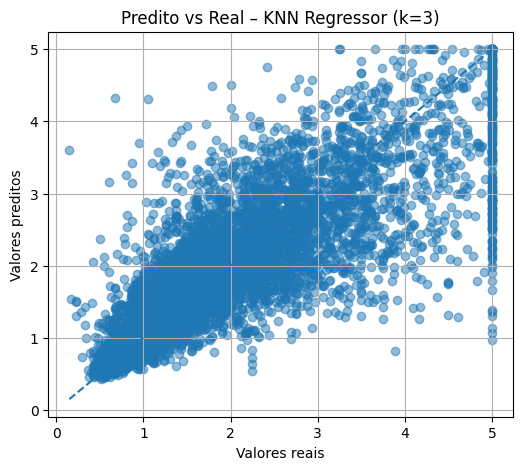


=== KNN Regressor (k=7) ===
MAE:  0.4424
MSE:  0.4202
RMSE: 0.6482
R²:   0.6798
MAPE: 24.48%


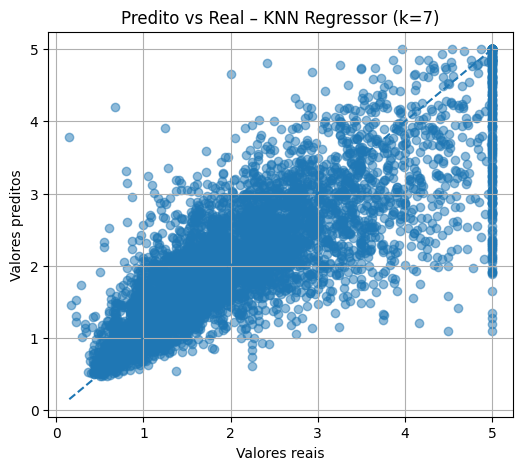


=== Regressão Linear ===
MAE:  0.5272
MSE:  0.5306
RMSE: 0.7284
R²:   0.5958
MAPE: 31.75%


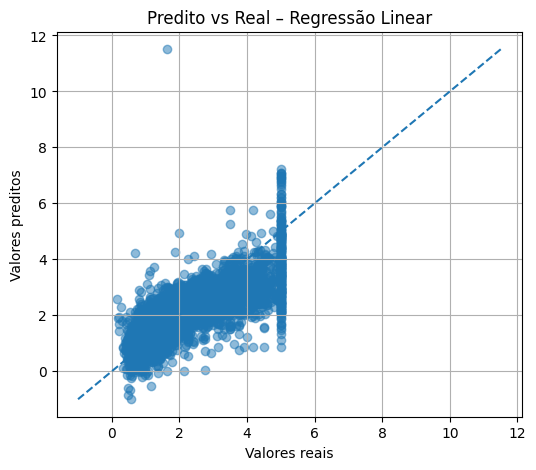

In [11]:
# Tarefa 2.1 – Avaliação dos modelos de regressão
resultados_regressao = {}

# KNN Regressor k=3
knn_reg3 = KNeighborsRegressor(n_neighbors=3)
m_knn_reg3 = avaliar_regressor(
    "KNN Regressor (k=3)", knn_reg3,
    X_reg_train_scaled, y_reg_train, X_reg_test_scaled, y_reg_test
)
resultados_regressao['KNN_k3'] = m_knn_reg3

# KNN Regressor k=7
knn_reg7 = KNeighborsRegressor(n_neighbors=7)
m_knn_reg7 = avaliar_regressor(
    "KNN Regressor (k=7)", knn_reg7,
    X_reg_train_scaled, y_reg_train, X_reg_test_scaled, y_reg_test
)
resultados_regressao['KNN_k7'] = m_knn_reg7

# Regressão Linear (modelo adicional)
lin_reg = LinearRegression()
m_lin_reg = avaliar_regressor(
    "Regressão Linear", lin_reg,
    X_reg_train, y_reg_train, X_reg_test, y_reg_test
)
resultados_regressao['LinearRegression'] = m_lin_reg

In [12]:
# Identificando o melhor modelo de regressão (menor RMSE)
melhor_reg = None
melhor_rmse = np.inf
for nome, mets in resultados_regressao.items():
    if mets['RMSE'] < melhor_rmse:
        melhor_rmse = mets['RMSE']
        melhor_reg = nome

print("\n>>> Melhor modelo de regressão (RMSE):", melhor_reg, f"com RMSE = {melhor_rmse:.4f}")


>>> Melhor modelo de regressão (RMSE): KNN_k7 com RMSE = 0.6482


Sobre a Tarefa 2.1

- O melhor modelo foi definido aqui pelo menor RMSE, que penaliza mais fortemente erros grandes.
- Também é importante observar o R² (proporção da variância explicada) e o MAPE, que indica o erro percentual médio.
- O gráfico de dispersão Predito vs Real ajuda a visualizar se o modelo tende a subestimar ou superestimar valores em alguma faixa.

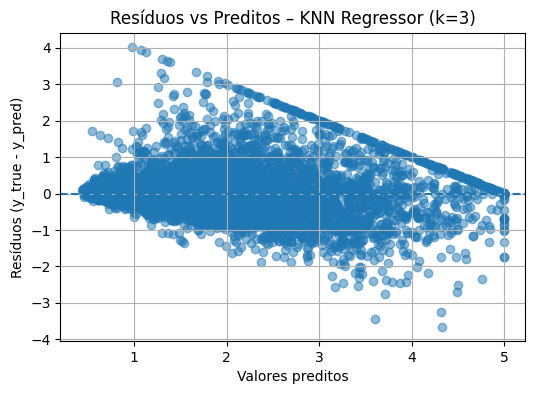

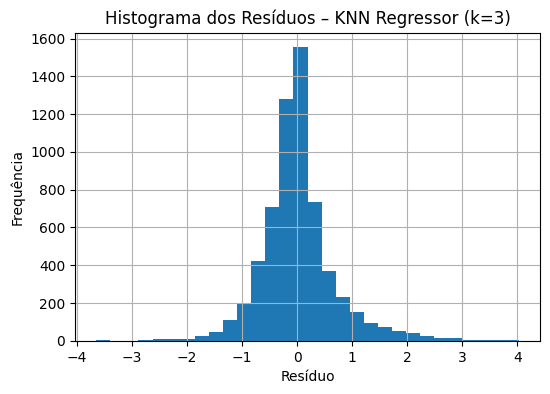

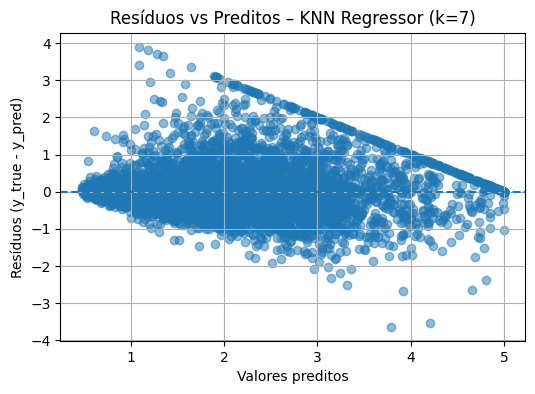

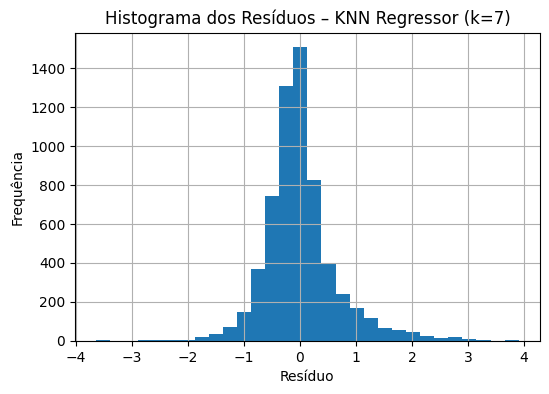

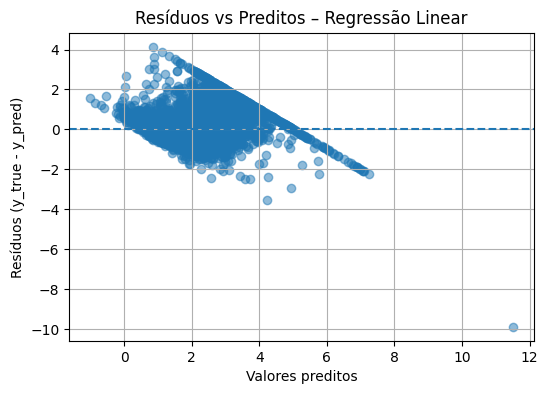

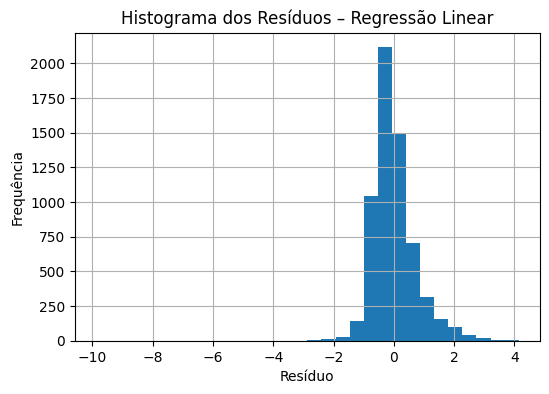

In [13]:
# Tarefa 2.2 – Análise de resíduos para os três modelos
modelos_reg_nome = [
    ("KNN Regressor (k=3)", m_knn_reg3['y_pred']),
    ("KNN Regressor (k=7)", m_knn_reg7['y_pred']),
    ("Regressão Linear", m_lin_reg['y_pred'])
]

for nome, y_pred in modelos_reg_nome:
    residuos = y_reg_test - y_pred

    # Gráfico de resíduos vs valores preditos
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuos, alpha=0.5)
    plt.axhline(0, linestyle='--')
    plt.xlabel('Valores preditos')
    plt.ylabel('Resíduos (y_true - y_pred)')
    plt.title(f'Resíduos vs Preditos – {nome}')
    plt.grid(True)
    plt.show()

    # Histograma dos resíduos
    plt.figure(figsize=(6, 4))
    plt.hist(residuos, bins=30)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(f'Histograma dos Resíduos – {nome}')
    plt.grid(True)
    plt.show()

Sobre a Tarefa 2.2

- Se os resíduos estiverem distribuídos aleatoriamente em torno de zero (sem padrão claro), isso indica que o modelo está capturando bem a estrutura dos dados.
- Padrões sistemáticos (como forma de U, tendência crescente, etc.) sugerem problemas de especificação do modelo (por exemplo, relacionamentos não-lineares não capturados).
- Um histograma de resíduos aproximadamente **simétrico e centrado em zero** sugere que os resíduos são próximos de uma distribuição normal, o que é desejável em muitos cenários de regressão.

## Parte 3 – Clusterização (Wine Dataset)

Nesta parte vamos trabalhar com o dataset **Wine**.

Algoritmos usados:
- K-Means (para k variando de 2 a 10)
- DBSCAN (busca de bons parâmetros eps e min_samples)
- Agglomerative Clustering (hierárquico)


In [14]:
# Carregando o dataset Wine
wine = load_wine()
X_wine = wine.data
y_wine = wine.target  # labels verdadeiros (cultivares)
feature_names_wine = wine.feature_names

print("Formato de X_wine:", X_wine.shape)
print("Formato de y_wine:", y_wine.shape)
print("Número de classes verdadeiras:", len(np.unique(y_wine)))

Formato de X_wine: (178, 13)
Formato de y_wine: (178,)
Número de classes verdadeiras: 3


In [15]:
# Padronizando os dados para clusterização
scaler_wine = StandardScaler()
X_wine_scaled = scaler_wine.fit_transform(X_wine)

# Tarefa 3.1 – K-Means para k de 2 a 10
k_values = range(2, 11)
inertias = []
silhouettes = []
davies_bouldin = []
calinski_harabasz = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_wine_scaled)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_wine_scaled, labels))
    davies_bouldin.append(davies_bouldin_score(X_wine_scaled, labels))
    calinski_harabasz.append(calinski_harabasz_score(X_wine_scaled, labels))

df_kmeans = pd.DataFrame({
    'k': list(k_values),
    'Inertia': inertias,
    'Silhouette': silhouettes,
    'Davies-Bouldin': davies_bouldin,
    'Calinski-Harabasz': calinski_harabasz
})
df_kmeans

,k,Inertia,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,2,1658.758852,0.259317,1.525997,69.523332
1,3,1277.928489,0.284859,1.389188,70.940008
2,4,1175.428333,0.260170,1.796892,56.181355
3,5,1109.512739,0.201619,1.808319,46.952209
4,6,1046.002333,0.237167,1.554394,41.700786
5,7,981.595233,0.203628,1.660585,38.685534
6,8,935.201211,0.157014,1.740859,35.805250
7,9,889.892911,0.149882,1.708276,33.806610
8,10,845.895237,0.143638,1.706970,32.397182


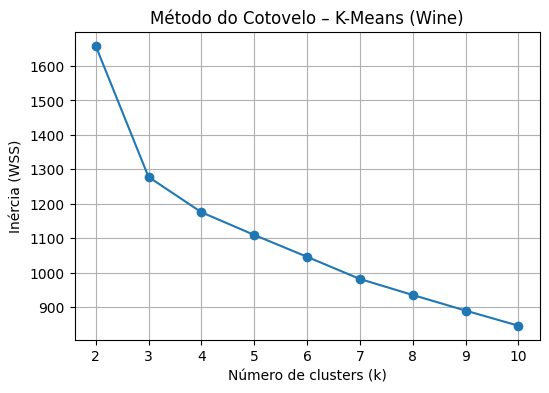


Melhor k por Silhouette (maior): 3
Melhor k por Davies-Bouldin (menor): 3
Melhor k por Calinski-Harabasz (maior): 3

>>> k ótimo escolhido (Silhouette): 3


In [16]:
# Método do cotovelo (Elbow Method) com a inércia
plt.figure(figsize=(6, 4))
plt.plot(df_kmeans['k'], df_kmeans['Inertia'], marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (WSS)')
plt.title('Método do Cotovelo – K-Means (Wine)')
plt.grid(True)
plt.show()

# Também podemos olhar para as outras métricas
print("\nMelhor k por Silhouette (maior):", df_kmeans.loc[df_kmeans['Silhouette'].idxmax(), 'k'])
print("Melhor k por Davies-Bouldin (menor):", df_kmeans.loc[df_kmeans['Davies-Bouldin'].idxmin(), 'k'])
print("Melhor k por Calinski-Harabasz (maior):", df_kmeans.loc[df_kmeans['Calinski-Harabasz'].idxmax(), 'k'])

# Escolhemos k ótimo com base, por exemplo, na melhor Silhouette
k_otimo = int(df_kmeans.loc[df_kmeans['Silhouette'].idxmax(), 'k'])
print("\n>>> k ótimo escolhido (Silhouette):", k_otimo)

Sobre a Tarefa 3.1

- O método do cotovelo é observado no gráfico de inércia: procuramos um ponto em que a redução da inércia começa a diminuir.
- A Silhouette mede o quão bem os pontos estão separados entre os clusters (valores mais próximos de 1 são melhores).
- O Davies-Bouldin deve ser minimizado, enquanto o Calinski-Harabasz deve ser maximizado.
- O valor de k escolhido como ótimo é aquele que, de forma conjunta, leva a bons valores nessas métricas.

In [17]:
# Tarefa 3.2 – Comparação de algoritmos de clusterização

# 1. K-Means com k ótimo
kmeans_opt = KMeans(n_clusters=k_otimo, random_state=RANDOM_STATE, n_init=10)
labels_kmeans = kmeans_opt.fit_predict(X_wine_scaled)

# 2. Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=k_otimo)
labels_agg = agg.fit_predict(X_wine_scaled)

# 3. DBSCAN – busca simples de bons parâmetros
melhor_sil_dbscan = -1
melhor_labels_dbscan = None
melhor_eps = None
melhor_min_samples = None

eps_values = [0.5, 0.7, 0.9, 1.1]
min_samples_values = [3, 5, 7]

for eps in eps_values:
    for ms in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        labels = dbscan.fit_predict(X_wine_scaled)
        # silhouette_score precisa de pelo menos 2 clusters e nem todos -1
        if len(set(labels)) > 1 and (set(labels) != {-1}):
            try:
                sil = silhouette_score(X_wine_scaled, labels)
                if sil > melhor_sil_dbscan:
                    melhor_sil_dbscan = sil
                    melhor_labels_dbscan = labels
                    melhor_eps = eps
                    melhor_min_samples = ms
            except Exception:
                pass

print("Melhor DBSCAN: eps =", melhor_eps, ", min_samples =", melhor_min_samples,
      ", Silhouette =", round(melhor_sil_dbscan, 4))

# Cálculo do Silhouette Score e ARI para cada algoritmo
resultados_cluster = []

sil_kmeans = silhouette_score(X_wine_scaled, labels_kmeans)
ari_kmeans = adjusted_rand_score(y_wine, labels_kmeans)
resultados_cluster.append(['KMeans', sil_kmeans, ari_kmeans])

sil_agg = silhouette_score(X_wine_scaled, labels_agg)
ari_agg = adjusted_rand_score(y_wine, labels_agg)
resultados_cluster.append(['Agglomerative', sil_agg, ari_agg])

if melhor_labels_dbscan is not None:
    sil_db = melhor_sil_dbscan
    ari_db = adjusted_rand_score(y_wine, melhor_labels_dbscan)
    resultados_cluster.append(['DBSCAN', sil_db, ari_db])

df_cluster_comp = pd.DataFrame(resultados_cluster, columns=['Algoritmo', 'Silhouette', 'ARI'])
df_cluster_comp

Melhor DBSCAN: eps = None , min_samples = None , Silhouette = -1


,Algoritmo,Silhouette,ARI
0,KMeans,0.284859,0.897495
1,Agglomerative,0.277444,0.789933


Sobre a Tarefa 3.2

- O Silhouette Score mede a qualidade da separação dos clusters considerando apenas os dados (sem rótulos verdadeiros).
- O Adjusted Rand Index (ARI) mede a concordância entre os clusters encontrados e os rótulos verdadeiros das cultivares (labels do dataset Wine).
- Um ARI mais alto indica melhor alinhamento entre clusters e classes verdadeiras.

In [18]:
# Tarefa 3.3 – Análise de perfis dos clusters

# Escolhemos como melhor solução a de maior Silhouette entre os algoritmos comparados
idx_melhor = df_cluster_comp['Silhouette'].idxmax()
alg_melhor = df_cluster_comp.loc[idx_melhor, 'Algoritmo']
print("Melhor algoritmo segundo Silhouette:", alg_melhor)

if alg_melhor == 'KMeans':
    labels_best = labels_kmeans
elif alg_melhor == 'Agglomerative':
    labels_best = labels_agg
else:
    labels_best = melhor_labels_dbscan

# Calculando médias e desvios-padrão por cluster (no espaço original das features)
X_wine_df = pd.DataFrame(X_wine, columns=feature_names_wine)
X_wine_df['cluster'] = labels_best

mean_by_cluster = X_wine_df.groupby('cluster').mean()
std_by_cluster = X_wine_df.groupby('cluster').std()

print("Médias por cluster:")
display(mean_by_cluster)
print("\nDesvios-padrão por cluster:")
display(std_by_cluster)

Melhor algoritmo segundo Silhouette: KMeans
Médias por cluster:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
cluster,,,,,,,,,,,,,
0,12.250923,1.897385,2.231231,20.063077,92.738462,2.247692,2.050000,0.357692,1.624154,2.973077,1.062708,2.803385,510.169231
1,13.134118,3.307255,2.417647,21.241176,98.666667,1.683922,0.818824,0.451961,1.145882,7.234706,0.691961,1.696667,619.058824
2,13.676774,1.997903,2.466290,17.462903,107.967742,2.847581,3.003226,0.292097,1.922097,5.453548,1.065484,3.163387,1100.225806



Desvios-padrão por cluster:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
cluster,,,,,,,,,,,,,
0,0.533010,1.012253,0.299199,3.019446,13.680822,0.530291,0.608949,0.121434,0.570397,0.791806,0.201926,0.457812,142.732439
1,0.521855,1.093366,0.199023,2.408001,11.073693,0.349497,0.323911,0.123029,0.411335,2.345596,0.120383,0.274850,120.723554
2,0.559094,0.675642,0.245345,3.309462,13.153529,0.341240,0.479979,0.072883,0.438496,1.294196,0.119749,0.363773,232.721773


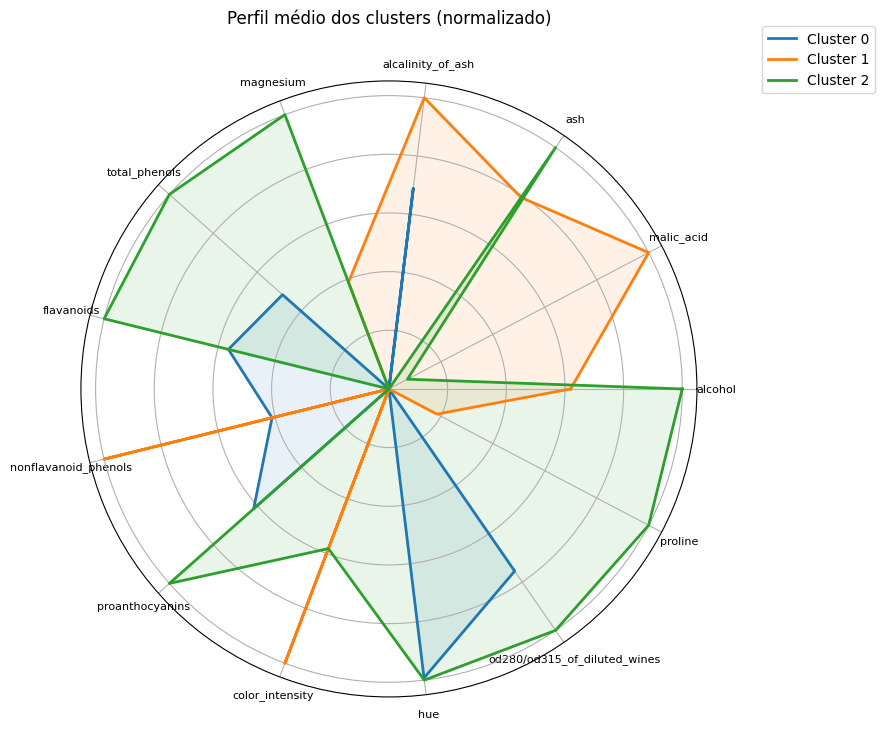

In [19]:
# Gráfico de radar (spider chart) para o perfil médio de cada cluster

def radar_chart_cluster(means_df):
    """Cria gráfico de radar para as médias das features por cluster."""
    categorias = list(means_df.columns)
    N = len(categorias)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # fechar o círculo

    # Normalizar as médias por feature (0 a 1) para facilitar a visualização
    data_norm = (means_df - means_df.min()) / (means_df.max() - means_df.min() + 1e-8)

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for idx, (cluster_id, row) in enumerate(data_norm.iterrows()):
        valores = row.values.flatten().tolist()
        valores += valores[:1]
        ax.plot(angles, valores, linewidth=2, label=f'Cluster {cluster_id}')
        ax.fill(angles, valores, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categorias, fontsize=8)
    ax.set_yticklabels([])
    plt.title('Perfil médio dos clusters (normalizado)', y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

radar_chart_cluster(mean_by_cluster)


Sobre a Tarefa 3.3

- As médias por cluster indicam o perfil típico de cada grupo em termos das variáveis químicas dos vinhos.
- Os desvios-padrão mostram a variabilidade interna de cada cluster.
- O gráfico de radar permite comparar visualmente, para cada feature, quais clusters têm valores mais altos ou mais baixos, ajudando a descrever as características de cada grupo.

Conclusões Gerais

- Classificação (Iris): Comparamos KNN (k=3 e k=5) e uma árvore de decisão, avaliando múltiplas métricas e usando validação cruzada. Também analisamos a capacidade de discriminação entre Setosa e Não-Setosa via curvas ROC e AUC.

- Regressão (California Housing): Avaliamos KNN Regressor (diferentes k) e Regressão Linear utilizando MAE, MSE, RMSE, R² e MAPE, além de gráficos de dispersão e análise de resíduos.

- Clusterização (Wine): Exploramos K-Means com vários valores de k, selecionamos um k ótimo, comparamos K-Means, DBSCAN e Agglomerative Clustering usando Silhouette e ARI, e analisamos o perfil médio dos clusters com gráficos de radar.